# Suter 2020

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('qDNA-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q

In [3]:
# parameters
register_config = [('NV', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]
bath_configs = list( load_spin_baths('Dominik_C13', DATA_DIR).values() )[:10]

kwargs = dict(suter_method=True, instant_pulses=True, verbose=False,
             old_state=bell_state, target=bell_state, env_approx_level='no_bath')

## Hamiltonian

In [4]:
kwargs = dict(suter_method=True, verbose=False)

C13_pos = (8.713976612205478e-10, 0.0, 1.901805289026213e-10) # Suter (calculated using Suter's dipolar coupling strengths)
register_config = [('NV0', (0, 0, 0), 0, {}), ('C13', C13_pos, 0, {})]
approx_level = 'no_bath'

hamiltonian = Hamiltonian(register_config, [], approx_level)
my_ham = hamiltonian.calc_matrices()[0]
suter_ham =  H_Suter()

print( 'Dennis: ', my_ham )
print( 'Suter: ', suter_ham )

Calculating Hamiltonians for no_bath: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Time to calculate the Hamiltonians: 0.007752180099487305 s.
Dennis:  Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-79254.00000013      0.              0.              0.        ]
 [     0.          79254.00000013      0.              0.        ]
 [     0.              0.         -67148.31679238  -8760.69179506]
 [     0.              0.          -8760.69179506  67148.31679238]]
Suter:  Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-79000.      0.      0.      0.]
 [     0.  79000.      0.      0.]
 [     0.      0.  -3000. -55000.]
 [     0.      0. -55000.   3000.]]


## Instant Hadamard (Appendix)

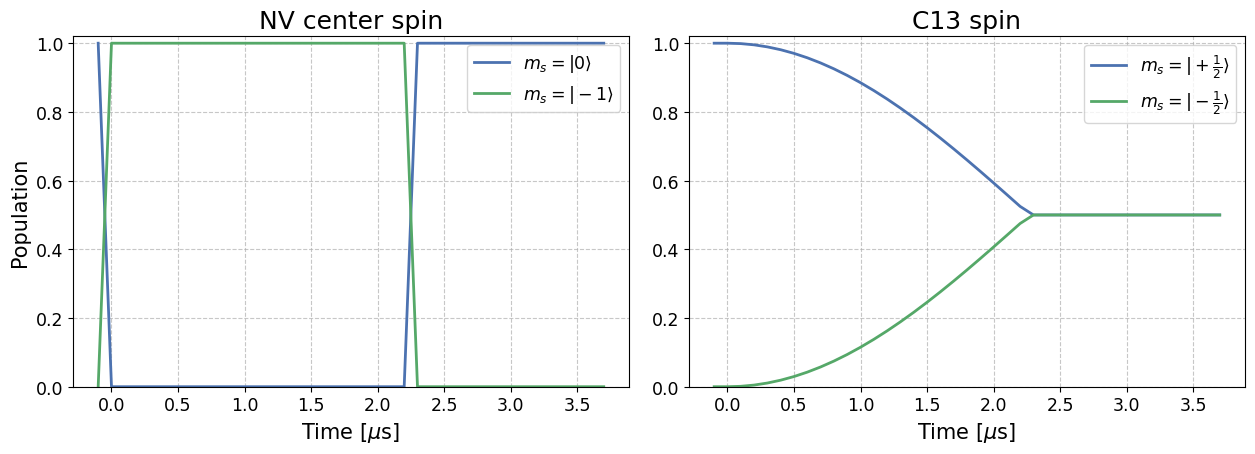

In [16]:
# Analytical times 
C13_pos = (8.713976612205478e-10, 0.0, 1.901805289026213e-10) # Suter (calculated using Suter's dipolar coupling strengths)
T1, T2 = calc_hadamard_pulse_seq(C13_pos, suter_method=True)

# C13 superposition 
NV_state = q.basis(2,0)
C13_state = 1/np.sqrt(2) * ( q.basis(2,0) + q.basis(2,1) )
target = q.tensor(NV_state*NV_state.dag(), C13_state*C13_state.dag())

kwargs = dict(suter_method=True, target=target, instant_pulses=True, verbose=False)
env = Environment(register_config, [], **kwargs)
pulse_seq = [0, T1, T2, np.pi, np.pi, 0, 0]
t_list = np.arange(-0.1e-6, (T1+T2), 0.1e-6)
new_states = env.get_new_register_states(pulse_seq, t_list=t_list)

fig, ax = plot_pops(t_list, new_states)

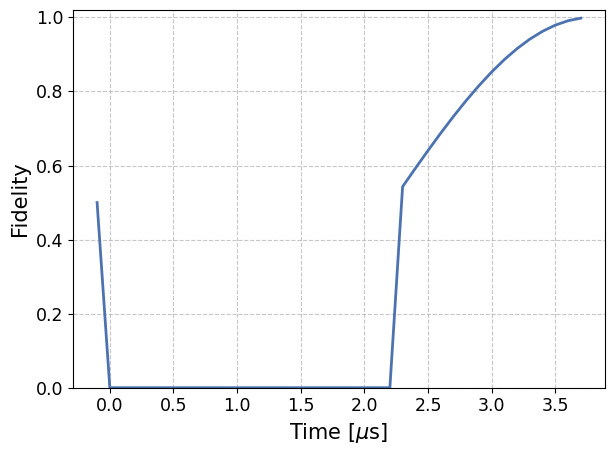

In [18]:
fidelities = env.get_values(pulse_seq, 'fidelity', t_list=t_list)
fig, ax = plot_fids(t_list, fidelities)